In [1]:
%matplotlib inline

In [2]:
import scipy
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.formula.api as sm
import cartopy.crs as ccrs
import pymc3 as pm

In [3]:
bayesreg_out_path = './data_parsed/bayesreg_d18ow.nc'

ss_nc_path = 'https://data.nodc.noaa.gov/thredds/dodsC/woa/WOA13/DATAv2/salinity/netcdf/decav/1.00/woa13_decav_s00_01v2.nc'
d18ow_nc_path = './data_raw/LeGrande_Schmidt2006 v1p1 d18o.nc'

In [4]:
def latlon2xyz(lat, lon):
    latr = np.deg2rad(lat)
    lonr = np.deg2rad(lon)
    x = np.cos(latr) * np.cos(lonr)
    y = np.cos(latr) * np.sin(lonr)
    z = np.sin(latr)
    return x, y, z


def chord_distance(lat1, lon1, lat2, lon2):
    x1, y1, z1 = latlon2xyz(lat1, lon1)
    x2, y2, z2 = latlon2xyz(lat2, lon2)
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)


def distance_array(df):
    """Compute distance matrix

    Compute distance for a pandas dataframe with columns
    'grid', 'lat', 'lon'.
    """
    # This is a terrible way to do this. Need to vectorize the shit out of this.
    n = len(df)
    out = np.zeros((n, n))
    for i, d1 in df.iterrows():
        for j, d2 in df.iterrows():
            # out[i, j] = distance(d1.lon, d1.lat, d2.lon, d2.lat)
            out[i, j] = chord_distance(d1.lat, d1.lon, d2.lat, d2.lon)
    return out

In [5]:
# Read in data.
ds = xr.open_dataset(ss_nc_path, decode_times=False).load()
do = xr.open_dataset(d18ow_nc_path)

In [6]:
# Combine into single DataSet.
# TODO(brews): Ensure that we're getting np.nans if one of the values is missing at a grid point. We need to have all obs at all points!
dall = (xr.merge([do.d18o, ds.s_mn], compat='equals', join='inner')
        .squeeze())

In [7]:
# Spatial binning
latbins = np.arange(-90, 91, 20)
lonbins = np.arange(-180, 181, 20)
filled = np.ones(dall.sel(depth = 0).s_mn.shape)
filled_lon = filled * np.digitize(dall.lon, lonbins)
filled_lat = filled * np.digitize(dall.lat, latbins)[:, np.newaxis]
x = list(zip(filled_lat.flat, filled_lon.flat))
x_unique = list(set(x))
x_labeled_flat = np.array([x_unique.index(i) for i in x])
x_labeled = x_labeled_flat.reshape(filled.shape)
dall['grid'] = (('lat', 'lon'), x_labeled)

grid_pops = {}
for g in np.unique(x_labeled):
    grid_pops[g] = dall.where(dall.grid == g, drop = True)

latlon = {}
for k, v in grid_pops.items():
    latlon[k] = (np.float(v.lat.mean()), np.float(v.lon.mean()))
latlon_df = pd.DataFrame(latlon).T.reset_index()
latlon_df.columns = ['grid', 'lat', 'lon']

In [8]:
# Grab values we need at depth 0.
df = pd.DataFrame(columns=['grid', 'd18ow', 'sss'])
for k, v in grid_pops.items():
    target = v.sel(depth=0)
    out = pd.DataFrame({'d18ow': target.d18o.values.flatten(),
                        'sss': target.s_mn.values.flatten()})
    out['grid'] = k
    out = out.dropna(axis='index', how = 'any')
    df = df.append(out, ignore_index=True)
    
df.sort_values('grid', inplace=True)

# Ordinary linear regression

In [9]:
# Fit a linear model to d18ow and ss. Not Bayes.
d18ow_ols_fit = pd.DataFrame(columns = ['intercept', 'coef', 'rsquared_adj', 'grid', 'n'])
for group, d_sub in df.groupby('grid'):
    fit = sm.ols(formula = 'd18ow ~ sss', data = d_sub).fit()
    d18ow_ols_fit = d18ow_ols_fit.append({'intercept': fit.params['Intercept'],
                              'coef': fit.params['sss'],
                              'rsquared_adj': fit.rsquared_adj,
                              'mse_resid': fit.mse_resid,
                              'grid': group, 
                              'n': len(d_sub)}, ignore_index = True)

In [10]:
# d18osw_ols_fit = d18osw_ols_fit.query('n >= 30')

df_all = pd.merge(latlon_df, d18ow_ols_fit, on='grid')

# Calculate distance between mean grid centers and do semivariogram
distance_matrix = distance_array(df_all)

In [11]:
## Maps of non-Bayes regressions
df_field = df_all.set_index(['lat', 'lon']).to_xarray()

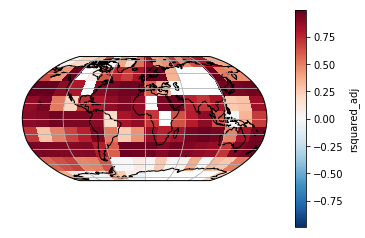

In [12]:
ax = plt.subplot(projection=ccrs.Robinson())
df_field.rsquared_adj.plot(ax=ax, transform=ccrs.PlateCarree())
ax.gridlines()
ax.coastlines()

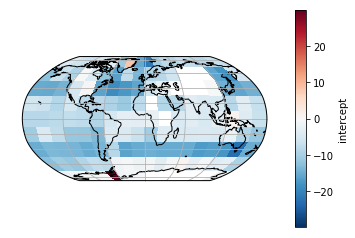

In [13]:
ax = plt.subplot(projection=ccrs.Robinson())
df_field.intercept.plot(ax=ax, transform=ccrs.PlateCarree())
ax.gridlines()
ax.coastlines()

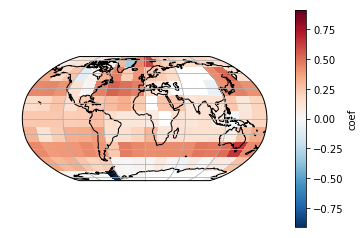

In [14]:
ax = plt.subplot(projection=ccrs.Robinson())
df_field.coef.plot(ax=ax, transform=ccrs.PlateCarree())
ax.gridlines()
ax.coastlines()

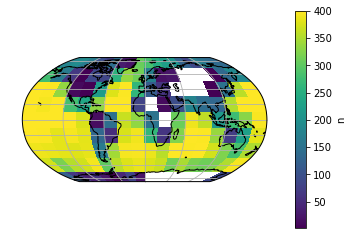

In [15]:
ax = plt.subplot(projection=ccrs.Robinson())
df_field.n.plot(ax=ax, transform=ccrs.PlateCarree())
ax.gridlines()
ax.coastlines()

# Bayesian regression

In [16]:
# Playing with basic pymc3 model
df = pd.merge(latlon_df, df, on='grid')
n_grid = len(df_all['grid'].unique())
idx_grid = pd.Categorical(df['grid']).codes

with pm.Model() as model0:

    # Hyperparameters
    mu_a = pm.Normal('μ_α', mu=0, sd=1)
    sigma_a = pm.HalfCauchy('σ_α', beta=1)

#     mu_b = pm.Normal('mu_beta', mu=0, sd=1)
    mu_b = pm.HalfCauchy('μ_β', beta=1)
    sigma_b = pm.HalfCauchy('σ_β', beta=1)

    # Intercept and slope
    a = pm.Normal('α', mu=mu_a, sd=sigma_a, shape=n_grid)
    b = pm.Normal('β', mu=mu_b, sd=sigma_b, shape=n_grid)
#     b = pm.HalfCauchy('beta', beta=1, shape=n_grid)
    # Model error
    tau = pm.HalfCauchy('τ', beta=1, shape=n_grid)

    # Likelihood
    d18o_est = a[idx_grid] + b[idx_grid] * df['sss']
    likelihood = pm.Normal('y', mu=d18o_est, sd=tau[idx_grid], 
                           observed=df['d18ow'])

    trace0 = pm.sample(5000, njobs=1, init='advi_map')

Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...
logp = 21,434, ||grad|| = 51,961: : 5001it [00:21, 230.40it/s]                            

Average Loss = -28,668:  42%|████▏     | 83082/200000 [06:19<08:54, 218.67it/s]   
Convergence archived at 83100
Interrupted at 83,099 [41%]: Average Loss = 3.337e+08
100%|██████████| 5500/5500 [3:49:40<00:00,  2.51s/it]  /home/sbm/miniconda3/envs/deltaoxfox/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:459: UserWarning: Chain 0 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)
/home/sbm/miniconda3/envs/deltaoxfox/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 1219 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))



### Diagnotics

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f304d65e630>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f3050c4db70>]], dtype=object)

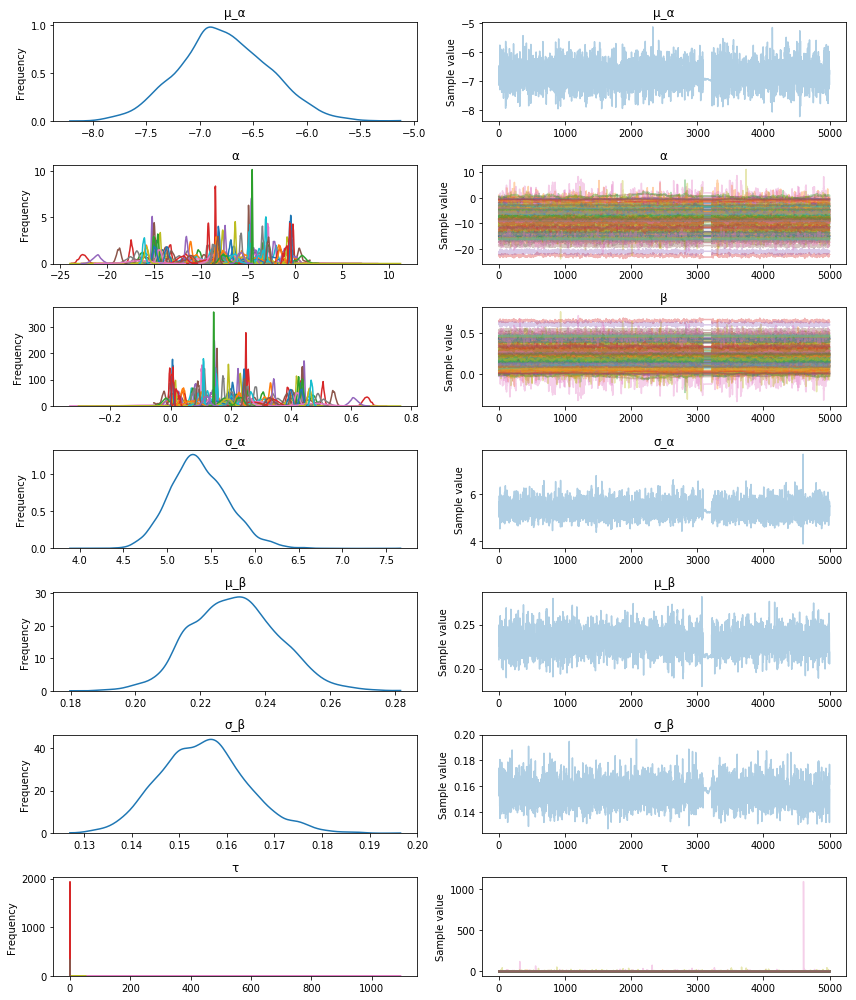

In [17]:
pm.traceplot(trace0)

In [18]:
df_all['α'] = trace0.get_values('α').mean(axis=0)
df_all['β'] = trace0.get_values('β').mean(axis=0)
df_all['τ'] = trace0.get_values('τ').mean(axis=0)

df_field_bayes = df_all.set_index(['lat', 'lon']).to_xarray()

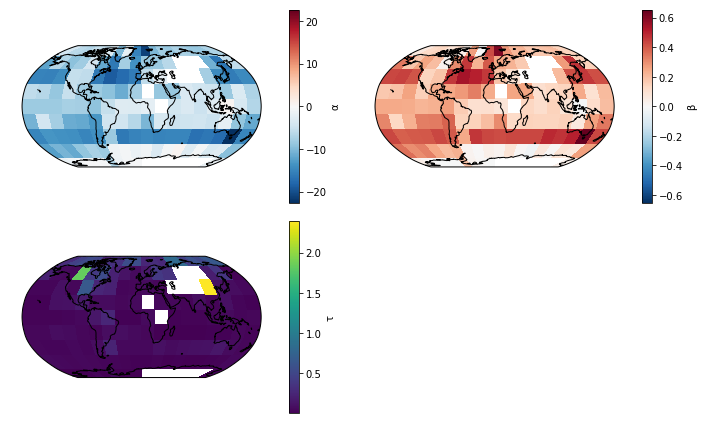

In [30]:
plt.figure(figsize=(10, 6))
ax = plt.subplot(2, 2, 1, projection=ccrs.Robinson())
df_field_bayes['α'].plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()

ax = plt.subplot(2, 2, 2, projection=ccrs.Robinson())
df_field_bayes['β'].plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()

ax = plt.subplot(2, 2, 3, projection=ccrs.Robinson())
df_field_bayes['τ'].plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()

plt.tight_layout()

### Output model to file

In [20]:
latlon_zip = list(df_all[['lat', 'lon']].to_records(index=False))

latlon_idx = pd.MultiIndex.from_tuples(latlon_zip, names=['lat', 'lon'])
x_alpha = pd.DataFrame(trace0.get_values('α').T, index=latlon_idx).stack()
x_alpha.index.rename('sim', level=2, inplace=True)

x_beta = pd.DataFrame(trace0.get_values('β').T, index=latlon_idx).stack()
x_beta.index.rename('sim', level=2, inplace=True)

x_tau2 = pd.DataFrame(trace0.get_values('τ').T ** 2, index=latlon_idx).stack()
x_tau2.index.rename('sim', level=2, inplace=True)

out = xr.Dataset({'alpha': x_alpha.to_xarray(),
                  'beta': x_beta.to_xarray(),
                  'tau2': x_tau2.to_xarray()})

In [21]:
out.to_netcdf(bayesreg_out_path)